# Image Recognition via Vietoris-Rips Complex

In [1]:
import numpy as np
from scipy.sparse import csr_matrix, csgraph
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
def calc_vertice_index(k, i, j):
    """Calculate index of a vertice: g(v_{k,i,j}) = (k + 1) * i + j + sum_{l=0}^{k} l^2

    Args:
        k (int): N - k is the length of the side of the square.
        i (int): Row index of left top the square in a image.
        j (int): Column index of left top the square in a image.

    Returns:
        int: The index of the vertice.
    """    
    index = (k + 1) * i + j + np.array([l ** 2 for l in range(k + 1)]).sum()
    return index

def get_vertice(image, k, i, j):
    """Get a square (a vertice in the graph) from a given image.
       v_{k,i,j} = [N, N - k, i] * [N, N - k, j] in V_{N, N}

    Args:
        image (np.array): N * N gray scale image.
        k (int): N - k is the length of the side of the square.
        i (int): Row index of left top the square in a image.
        j (int): Column index of left top the square in a image.

    Returns:
        np.array: A k * k gray scale sub-image.
    """    
    square_width = image.shape[0] - k
    vertice = image[i: (i + square_width), j: (j + square_width)]
    return vertice

def connect_two_vertices(vertice_from, vertice_to, total_num_color, error_parameter, scaling_const, and_condition=True):
    """
    if and_condition == True:
        Connect the two vertices if both of them have the larger number of colors than a threshold. 
            Connect if #f(v_1) >= #f(image) - n * epsilon AND #f(v_2) >= #f(image) - n * epsilon.
    else:
        Connect the two vertices if the difference between the colors of the vertices is greater than error_parameter.
            Connect if  |#f(v_2) = #f(v_1)| >= epsilon.        

    Args:
        vertice_from (np.array[int]): A gray scale sub-image (vertice 1).
        vertice_to (np.array[int]): A gray scale sub-image (vertice 2).
        total_num_color (int): The number of colors of the image.
        error_parameter (float): Error paramter that determines if two vertices are connected or not (epsilon).
        scaling_const (float): Another paramter that determines if two vertices are connected or not (n).
        and_condition (bool): If True, we connect vertices when #f(v_1) AND #f(v_2) are greater than a threshold,
                              else, we connect vertices when |#f(v_1) - #f(v_2)| is greater than a threshold.

    Returns:
        int: 1 if the two vertices are connected else 0.
    """
    if and_condition:
        threshold_to_connect = total_num_color - scaling_const * error_parameter
        if (np.unique(vertice_from).size > threshold_to_connect) and (np.unique(vertice_to).size > threshold_to_connect):
            weight = 1
        else:
            weight = 0
    else:
        threshold_to_connect = error_parameter
        if np.abs(np.unique(vertice_from).size - np.unique(vertice_to).size) > threshold_to_connect:
            weight = 1
        else:
            weight = 0
    return weight
    


## Construction of the 1-Skelton of the Vietoris-Rips Complex Using All Squares

In [3]:
def construct_one_skelton(image, error_parameter=10.0, scaling_const=1.0):
    """Construct 1-skelton of the Vietoris-Rips Complex using all squares of a image.

    Args:
        image (np.array): N * N gray scale image.
        error_parameter (float): Error paramter that determines if two vertices are connected or not (epsilon).
        scaling_const (float): Another paramter that determines if two vertices are connected or not (n).

    Returns:
        Tuple[List, List, List]: V_from (Index list of vertices), V_to (Index list of vertices), and edges between the vertices.
    """    
    image_size = image.shape[0]
    ids_vertices_from = []
    ids_vertices_to = []
    edges = []
    total_num_color = np.unique(image).size

    for k in tqdm(range(image_size - 1)):
        for i in range(k + 1):
            for j in range(k + 1):
                vertice_id_k_i_j = calc_vertice_index(k, i, j)

                for square_pos_row in range(i, i + 2):
                    for square_pos_column in range(j, j + 2):
                        ids_vertices_from.append(vertice_id_k_i_j)
                        ids_vertices_to.append(calc_vertice_index(k + 1, square_pos_row, square_pos_column))
                        edges.append(
                            connect_two_vertices(
                                get_vertice(image, k, square_pos_row, square_pos_column),
                                get_vertice(image, k + 1, square_pos_row, square_pos_column),
                                total_num_color,
                                error_parameter,
                                scaling_const
                                )
                            ) 

    return ids_vertices_from, ids_vertices_to, edges



## Highlighting Minimal Size Squares

### Load an Image

In [11]:
IMAGE_TYPE = 'tea'  # NOTE: 'tea' or 'squirrel'
IMAGE_ADDRESS = f'img/{IMAGE_TYPE}.png'
IMAGE_SIDE_LENGTH = 100
IMAGE_RESIZE = (IMAGE_SIDE_LENGTH, IMAGE_SIDE_LENGTH)

pil_image = Image.open(IMAGE_ADDRESS)
pil_image = pil_image.resize(IMAGE_RESIZE).convert('L')
image = np.array(pil_image)

### Calculate Minimal Size Squares and Run Object Detection Based on the Result 

In [12]:
ERROR_PARAMETER = 10.0
SCALING_CONST = 19.0

ids_vertices_from, ids_vertices_to, edges = construct_one_skelton(image, error_parameter=ERROR_PARAMETER, scaling_const=SCALING_CONST)

# Construct a sparse graph in CSR format
compressed_sparse_matrix = csr_matrix((edges, (ids_vertices_from, ids_vertices_to)), shape = (max(ids_vertices_to) + 1, max(ids_vertices_to) + 1))
# Delete zeros that remain because of CSR format's specification.
# TODO: Will change not to append weight to edges when creating edges.
compressed_sparse_matrix.eliminate_zeros()
connected_component_ids = csgraph.connected_components(compressed_sparse_matrix)[1]  # The indices of connected components.

# Get the maximum index of vertices that is contained in the 0-th connected component (C_0).
max_vertice_id_in_cc_zero = np.where(connected_component_ids == 0)[0][-1]

# Get representative vertice id of each square size.
representative_vertice_ids_per_square_size = np.array([l ** 2 for l in range(IMAGE_SIDE_LENGTH + 1)])
representative_vertice_ids_per_square_size = [representative_vertice_ids_per_square_size[: l + 1].sum() for l in range(1, IMAGE_SIDE_LENGTH + 1)]

# The minimum index of vertices whose index is larger than the maximum index of vertices contained in the 0-th connected component.
k_prime = np.where(representative_vertice_ids_per_square_size > max_vertice_id_in_cc_zero)[0][0] 
square_side_length = IMAGE_SIDE_LENGTH - k_prime

# For squares with size of square_side_length at all positions in the image, replace zeros to sub-image if a vertex is contained in 0-th connected component (C_0).
detection_result = np.zeros_like(image)
for i in tqdm(range(k_prime + 1)):
    for j in range(k_prime + 1):
        if connected_component_ids[calc_vertice_index(k_prime, i, j)] == 0:
            detection_result[i: (i + square_side_length), j: (j + square_side_length)] = get_vertice(image, k_prime, i, j)


100%|██████████| 93/93 [00:00<00:00, 454.09it/s]


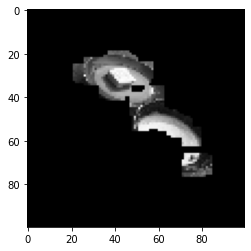

In [13]:
plt.imshow(detection_result, cmap = "gray")
plt.savefig(f'results/{IMAGE_TYPE}_epsilon={ERROR_PARAMETER}_n={SCALING_CONST}.png')
plt.show()